In [1]:
import numpy as np
from numpy import diff
from scipy.integrate import solve_ivp
from scipy.integrate import quad
import matplotlib.pyplot as plt

#Some plot settings
import matplotlib as mpl
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 20
mpl.rcParams['text.usetex'] = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# smoothing filter
from scipy.signal import savgol_filter

/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_728/3922867230.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Solución numérica Eq. (2.6) Tkachev

##### EDO: 

$ x(1+x)R''+(1+\frac{3x}{2})R'+\frac{1}{2}(\frac{M_t}{\frac{4\pi \rho_e a_e^3}{3}\xi^3 R^2}-R)=0 $

The total mass $M_t$ is the mass inside $R\xi$. 

But $M_t$ appears divided by the "average mass" inside the initial volume $\frac{4\pi \rho_e a_e^3}{3}\xi^3$ so we can define

$\bar M_t = \frac{M_t}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}$

This "relative mass fraction" is like an over(under)density that can remain constant IF THERE IS NO SHELL CROSSING. 
So Tkachev and Kolb called it $1+\Phi$, so 

$1+\Phi = \bar M_t = \frac{M_t}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}=\frac{\int_0^{r(\xi)}dr 4\pi r^2 \rho(r)}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}$

We can write

$ x(1+x)R''+(1+\frac{3x}{2})R'+\frac{1}{2}(\frac{\bar M_t(\xi)(x)}{R^2}-R)=0 $

$ x(1+x)R''+(1+\frac{3x}{2})R'+\frac{1}{2}(\frac{1+\Phi_i(x)}{R^2}-R)=0 $

where we have highlighed that $\bar M,\Phi$ can change in time. 

We will calculate $M$ as the sum over shell masses. 

We define a set of $\xi$'s $\xi = 0,1,2,3... $ and th3 shell particle, which has mass 

$m_{\xi_i} = m_i = \int_{\xi_i}^{\xi_{i+1}} \frac{dM}{dr}$, $\frac{dM}{dr}= 4\pi \xi^2 \rho(\xi)$

Text(0, 0.5, '$ M(\\xi_i)$ (unidades de $\\langle\\rho_{DM}\\rangle \\xi^3$)')

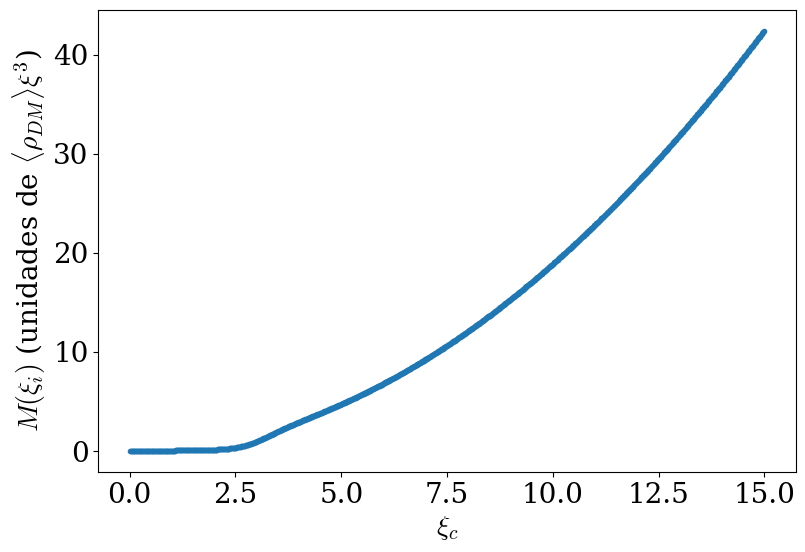

In [2]:
# shell borders until x = 10 
xi = np.linspace(0,1,1000)**(1/1)* 15
# shell centers
xic = 0.5*(xi[1:]+xi[:-1])
# INITIAL density profile, parameter rho0 is the central density
# Normalised to rho_DM_average (i.e. we need rho_i(r->inf)=1)

def rho_i(xi,rho0,xi_v,slope):
    return (1 - (1-rho0)/(1+np.exp(slope*(xi-xi_v)))) 
def dMdxi_i(xi,rho0,xi_v):
    return (4*np.pi*xi**2) * rho_i(xi,rho0,xi_v,slope)

# central density and radius
rho0, xi_v, slope = 0.1, 3, 3
plt.figure(figsize=(9,6))
#shell mass
m_xi = xic*0
for i in range(len(xi)-1):
    m_xi[i] = quad(dMdxi_i, xi[i], xi[i+1],args=(rho0, xi_v))[0]
plt.plot(xic,m_xi,'.')
#plt.plot(xic[200],m_xi[200],'.r')
plt.xlabel(r'$\xi_c$');plt.ylabel(r'$ M(\xi_i)$ (unidades de $\langle\rho_{DM}\rangle \xi^3$)')
#plt.savefig('shellmassH.pdf')

# Evolution

Reduce to 1st order diff. eq. using $R' = P$

$x(x+1)P' = -(1+\frac{3x}{2})P-\frac{1}{2}(\frac{\bar M_t(\xi)(x)}{R^2}-R)$

$R' = P$

iteration 

$x(x+1)(P_+-P_-) = -(1+\frac{3x}{2})\frac{P_++P_-}{2}\Delta x -\Delta x \frac{1}{2}(\frac{\bar M_t(\xi)(x)}{R^2}-R)$

$P_+ = P_-\frac{x(x+1)-(1+3x/2)\Delta x/2}{x(x+1)+(1+3x/2)\Delta x/2} - \frac{\Delta x}{x(x+1)+(1+3x/2)\Delta x/2} \frac{1}{2}(\frac{\bar  M_t(\xi)(x)}{R^2}-R)$

$R_+ = R_- + P\Delta x$


In [3]:
def itera(P,R,Dx,x,bMT):
    # P, R, MT are the values of P,R, bar M_T for each shell
    a = x*(x+1)-(1+3*x/2)*Dx/2
    b = x*(x+1)+(1+3*x/2)*Dx/2
    aP = P*a/b - Dx/b * 1/2 * (bMT/R**2-R)
    return aP, R + aP*Dx



# def evi(x,dxpar):
    

# Calculate $\bar M_T=1+\Phi$

We sum the masses of all points inside the physical distance $r$ and divide by the comoving volume

$1+\Phi = \bar M_t = \frac{M_t}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}=
\frac{1}{\frac{4\pi \rho_e a_e^3}{3}\xi^3}
\sum_{j/ r_j<r_i} M_{\xi_j}$

the discretisation works as ... $\int_0^{r(\xi)}dr 4\pi r^2 \rho(r)=\int dr \frac{dM}{dr}=\sum M$

In [4]:
# Javier's function
#def bMT(xic,m_xi,R):
 #   bMT= m_xi*0
  #  for i in range(len(xic)):
   #     bMT[i] = m_xi[np.abs(xic*R) < np.abs(xic[i]*R[i])].sum()    #sumamos todas las masas contenidas
    #return np.array(bMT)/(4*np.pi*xic**3/3)

def bMT(xi,m_xi,R,verbose=0):
    # mass inside boundary i
    bMT= xi*0 
    ii = np.arange(len(m_xi))
    boundaries = np.abs(xi*R)
    # lower un upper boundary
    b0 = boundaries[:-1]
    b1 = boundaries[1:]
    # check every boundary over boundaries
    for i in range(1,len(xi)):
        pb = boundaries[i]
        b0inm = (b0<=pb)
        b1inm = (b1<=pb)
        bMT[i] = m_xi[ np.logical_and(b0inm,b1inm)].sum()    #add all shells with both boundaries inside
        # crossed shells computed apart
        parti = bMT[i]/(4*np.pi*xi[i]**3/3)
        mm = np.logical_or(np.logical_and(b0inm,~b1inm),np.logical_and(~b0inm,b1inm))
        collection = ii[mm]
        if verbose>0 and len(collection)>0:
            print('i %d collecti0n '%(i),collection,parti)
        for shell in collection:
            # calculate mass inside boundary i assuming constant density in shell
            # m_i = int rho 4pi r^2 dr = bbb (r1^3-r0^3)
            # m_i_inside is bbb (pb^3-min(r0,r1)^3) = m_i (pb^3-min(r0,r1)^3)/abs((r1^3-r0^3))
            mshellinside= m_xi[shell] * (pb**3-min(b0[shell],b1[shell])**3)/np.abs(b0[shell]**3-b1[shell]**3)
            if verbose>0:
                print('i %d shell %d, %.2f/%.2f b0 %f b1 %f'%(i,shell,mshellinside,m_xi[shell],b0[shell],b1[shell]))
            bMT[i] += mshellinside
    aux= bMT[1:]/(4*np.pi*xi**3/3)[1:]
    a2 = xi*0
    a2[1:]=aux
    a2[0]=aux[0]
    return a2

In [5]:
# My function (tries to solve noise, fails)
#def bMT(xi,xic,m_xi,R):
 #   bMT = m_xi*0
  #  for i in range(len(xic)-1):
   #     rp = xi[i]*R[i]
    #    rm = xi[i-1]*R[i-1]
     #   rb = xi[i+1]*R[i+1] # What is rb ??
      #  rpb = min(rp,rb)
       # bMT[i] = (m_xi[np.abs(xic*R) < np.abs(xic[i]*R[i])]*((rpb**3-rm**3)/(rp**3-rm**3))).sum()
    #return np.array(bMT)/(4*np.pi*xic**3/3)

/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_728/165102683.py:9: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(xi,1-(xi_v/xi)**3,'k--', label=r'$1-(\xi_v/\xi_c)^3$')


(0.0, 1.1)

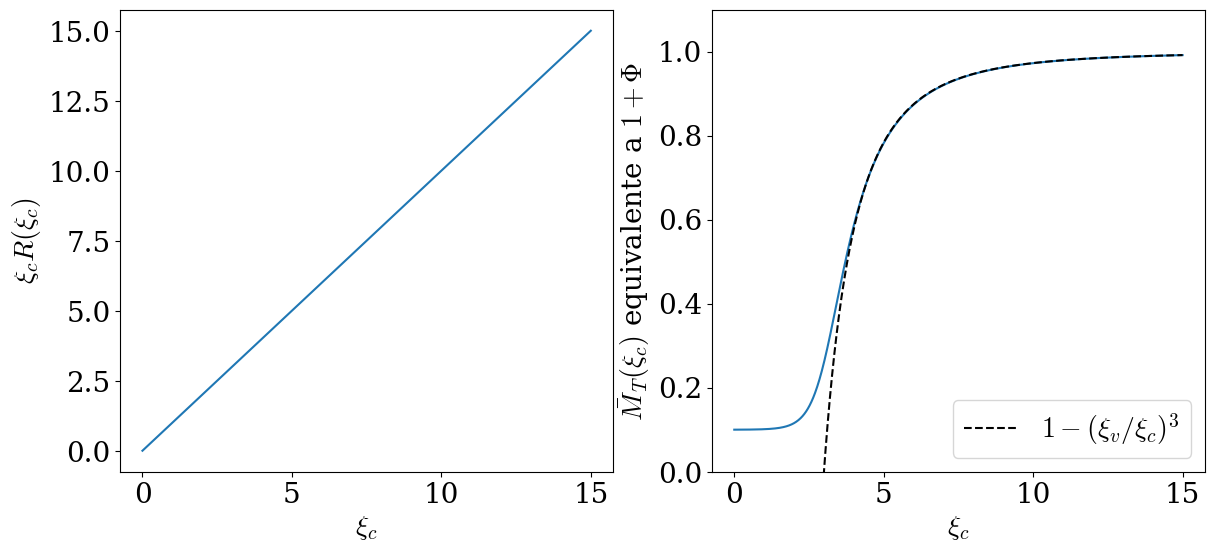

In [6]:
R=np.ones(len(xi))
bMT_0= bMT(xi,m_xi,R,verbose=0) #cambié añadir xi en todos los bMT()

fig,ax=plt.subplots(1,2,figsize=(14,6))
ax[0].plot(xi,xi*R)
ax[0].set_xlabel(r'$\xi_c$');ax[0].set_ylabel(r'$\xi_c R(\xi_c)$')

ax[1].plot(xi,bMT_0)
ax[1].plot(xi,1-(xi_v/xi)**3,'k--', label=r'$1-(\xi_v/\xi_c)^3$')
ax[1].set_xlabel(r'$\xi_c$');ax[1].set_ylabel(r'$\bar M_T(\xi_c)$ equivalente a $1+\Phi$')
ax[1].legend(loc='lower right')

ax[1].set_ylim(0,1.1)
#plt.savefig('totalmassH.pdf')

/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_728/1564406789.py:6: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(xi,1-(xi_v/xi)**3,'k--', label=r'$1-(\xi_v/\xi_c)^3$',linewidth=2)


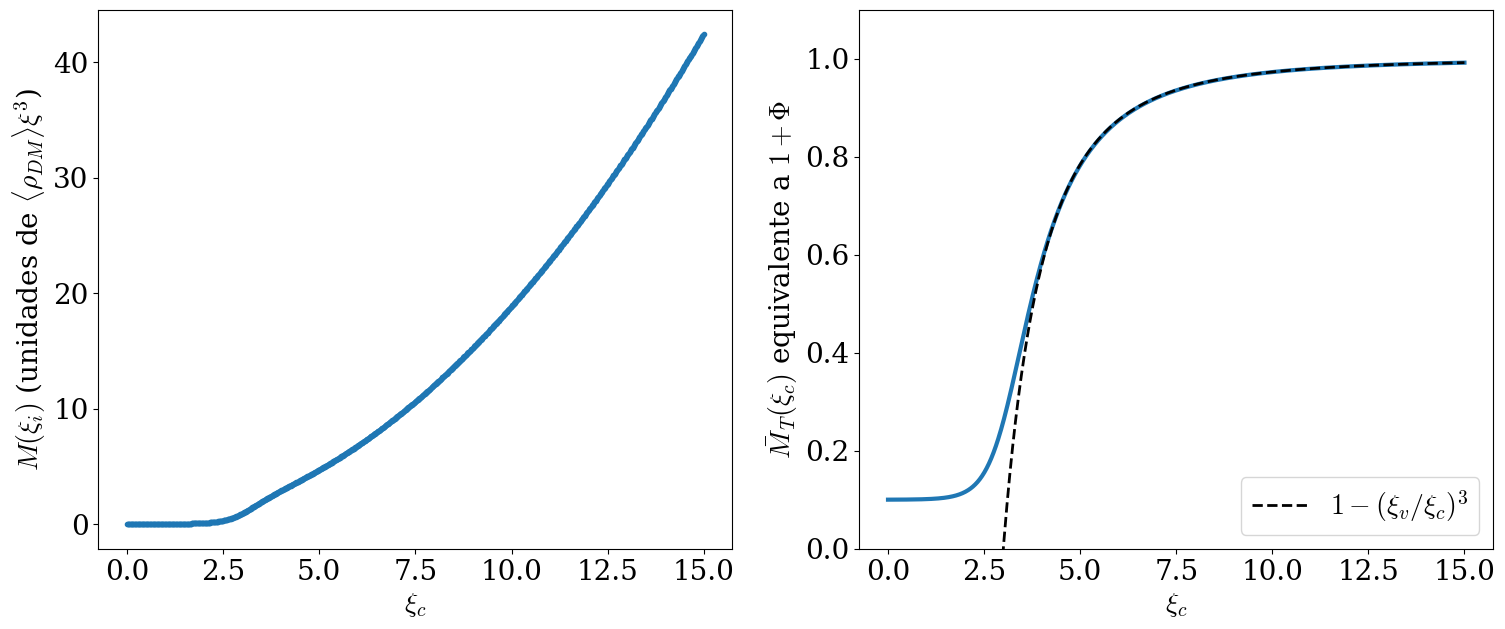

In [7]:
fig,ax=plt.subplots(1,2,figsize=(18,7))

ax[0].plot(xic,m_xi,'.')
ax[0].set_xlabel(r'$\xi_c$');ax[0].set_ylabel(r'$ M(\xi_i)$ (unidades de $\langle\rho_{DM}\rangle \xi^3$)')
ax[1].plot(xi,bMT_0,linewidth=3)
ax[1].plot(xi,1-(xi_v/xi)**3,'k--', label=r'$1-(\xi_v/\xi_c)^3$',linewidth=2)
ax[1].set_xlabel(r'$\xi_c$');ax[1].set_ylabel(r'$\bar M_T(\xi_c)$ equivalente a $1+\Phi$')
ax[1].set_ylim(0,1.1)
ax[1].legend(loc='lower right')

#plt.savefig('massesH.pdf')

In [8]:
# Define arrays
x = 1e-3
Rd  = R
Pd  = R*0
bMTd = bMT(xi,m_xi,Rd)
Rdl = []
Pdl = []
bMTl = []
xl  = []

In [9]:
# Evolve
#def evolo(it_number,x,Rd,Pd,bMTd,Rdl, Pdl, bMTl,xl,dxpar=10):

para      = 6
it_number = 110 * para
dxpar     = 10  * para
ditsave   = 1   * para
for i in range(it_number):
    Dx = x/dxpar
    Pd, Rd = itera(Pd,Rd,Dx,x,bMTd)
    bMTd = bMT(xi,m_xi,Rd)
    x=x+Dx
    if i%ditsave == 0:
        Pdl.append(Pd)
        Rdl.append(Rd)
        bMTl.append(bMTd)
        xl.append(x)
Pdla=np.array(Pdl)
Rdla=np.array(Rdl)
bMTla=np.array(bMTl)
xla= np.array(xl)

#    return Pdla, Rdla, bMTla, xla
#Pdla, Rdla, bMTla, xla = evolo(3,x,Rd,Pd,bMTd,Rdl, Pdl, bMTl,xl,dxpar=10)

# Results

Text(0, 0.5, '$r_i = \\xi R(\\xi)$')

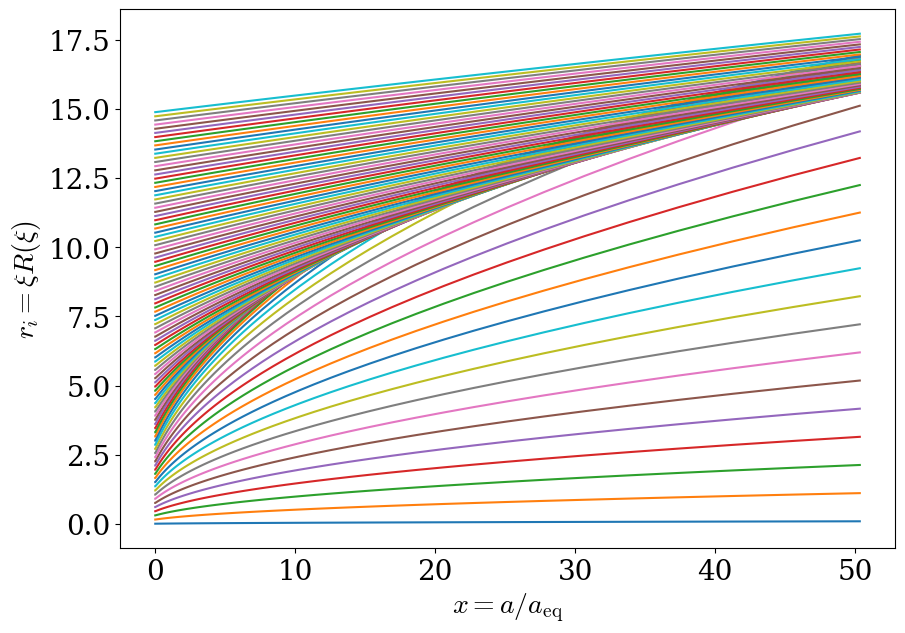

In [10]:
plt.figure(figsize=(10,7))
for i in range(1, len(xic)-1, 10):
    plt.plot(xla, xi[i]*Rdla[:,i],'-',label=r'$\xi = %d$'%i) 
    
#plt.plot(xla, xi[200]*Rdla[:,200],'w-',lw=2) 
    #plt.plot(xla, np.sqrt(1-((MTla[0,i]-1)*xla)))
plt.xlabel(r'$x=a/a_{\rm eq}$');plt.ylabel(r'$r_i = \xi R(\xi)$')
#plt.legend(prop={'size': 8})
#plt.savefig('shellevolutionH.pdf')

/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_728/2171448911.py:23: RuntimeWarning: divide by zero encountered in divide
  rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)


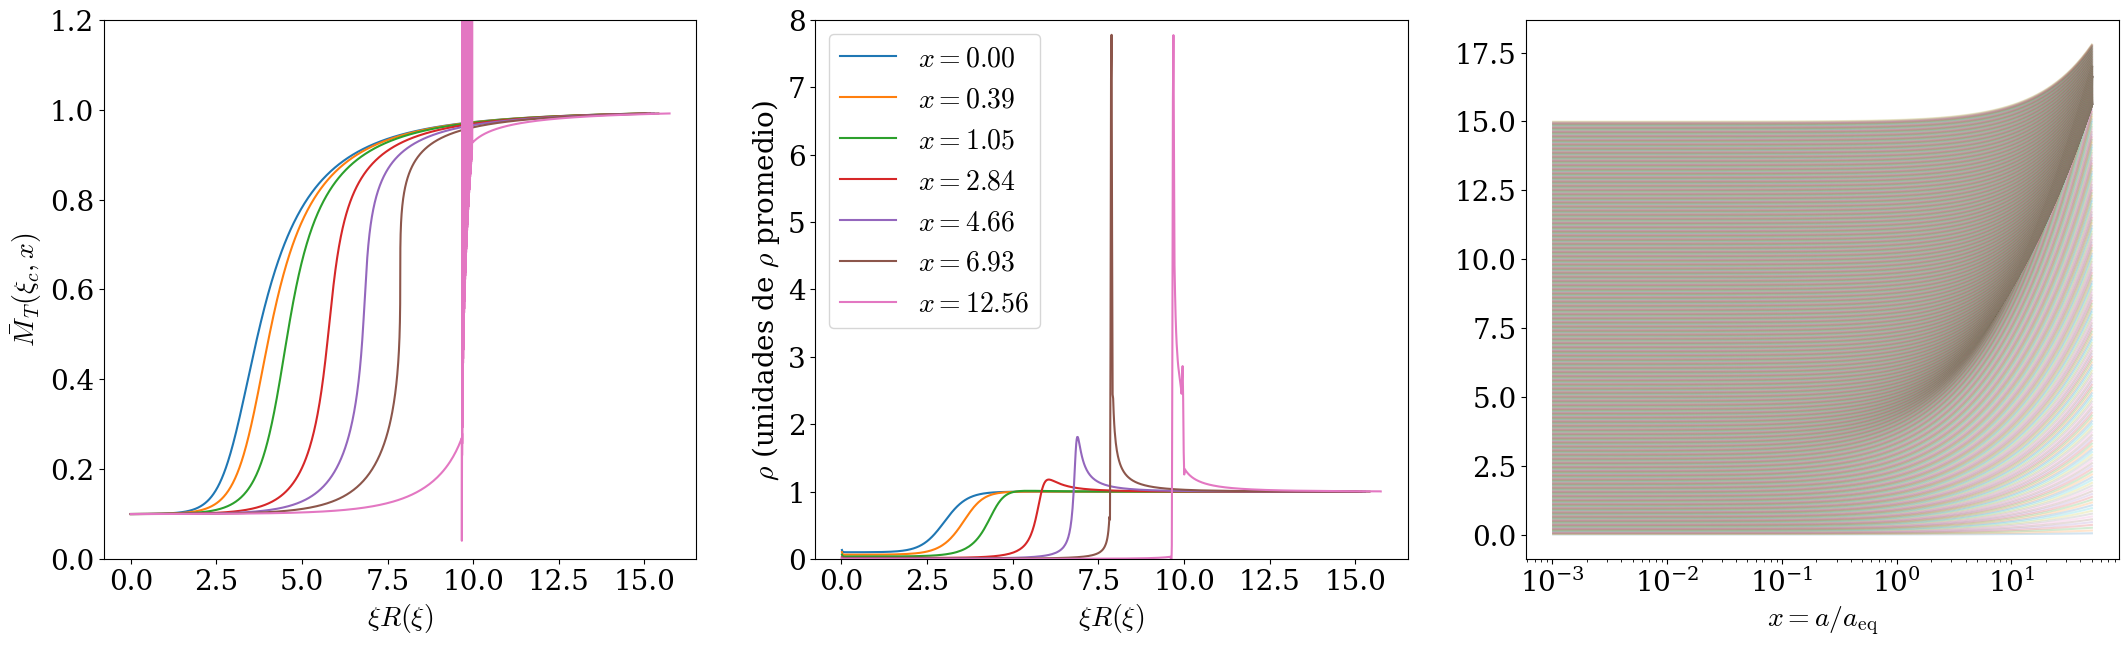

In [11]:
fig,ax=plt.subplots(1,3,figsize=(26,7))


for i in [0,-50,-40,-30,-25,-21,-15]:
    # physical coordinate radius
    ri =xi*Rdla[i]
    
    # ordering based on distance to center
    ord_ri = np.argsort(ri)
    ri_ord = ri[ord_ri]
           
    # Mass
    mass_ord = (bMTla[i]*4*np.pi/3*xi**3)[ord_ri]
    # Phi 
    Phi_ord = (bMTla[i])[ord_ri]
    ax[0].plot(ri_ord,Phi_ord,'-',label=r'$x = %.2f$'%xl[i])

    # local density estimate build from (dM/dr)/4pir^2
    # Recall bMT = Mass/4pixi^3/3
    r_tab_reg = np.linspace(ri_ord[0],ri_ord[-1],len(ri_ord))
    minterp = np.interp(r_tab_reg, ri_ord, mass_ord)
    smooth_mass_ord = savgol_filter(minterp, 5, 3)
    rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)

    ax[1].plot(r_tab_reg,rho,label=r'$x = %.2f$'%xl[i])
    
    
ax[1].set_ylim(0,8)
ax[0].set_ylim(0,1.2)
for i in range(len(xic)):
    ax[2].semilogx(xla,xic[i]*Rdla[:,i],label=r'$\xi = %.2f$'%xic[i],alpha=0.2)
ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$\bar M_T(\xi_c,x)$')
ax[1].set_xlabel(r'$\xi R(\xi)$');ax[1].set_ylabel(r'$\rho$ (unidades de $\rho$ promedio)')
ax[2].set_xlabel(r'$x=a/a_{\rm eq}$');#ax[2].set_ylabel(r'$\xi R(\xi)$')
ax[1].legend(loc='upper left', prop={'size': 20})
#ax[1].legend()

#plt.savefig('massdensityevolH.pdf')

/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_728/149140502.py:22: RuntimeWarning: divide by zero encountered in divide
  rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)
/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_728/149140502.py:29: RuntimeWarning: invalid value encountered in power
  ax.semilogy(xla,10/(5.5-xla)**1.5)


(0.1, 10)

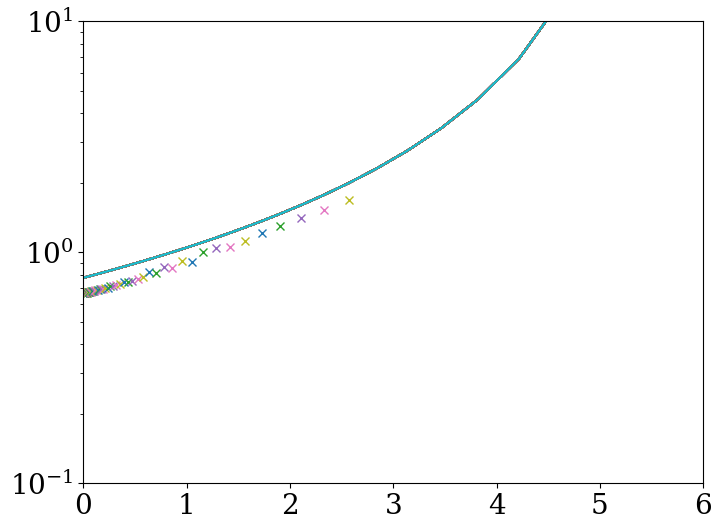

In [12]:
fig,ax=plt.subplots(1,figsize=(8,6))


for i in range(0,80):
    # physical coordinate radius
    ri =xi*Rdla[i]
    
    # ordering based on distance to center
    ord_ri = np.argsort(ri)
    ri_ord = ri[ord_ri]
           
    # Mass
    mass_ord = (bMTla[i]*4*np.pi/3*xi**3)[ord_ri]
    # Phi 
    Phi_ord = (bMTla[i])[ord_ri]

    # local density estimate build from (dM/dr)/4pir^2
    # Recall bMT = Mass/4pixi^3/3
    r_tab_reg = np.linspace(ri_ord[0],ri_ord[-1],len(ri_ord))
    minterp = np.interp(r_tab_reg, ri_ord, mass_ord)
    smooth_mass_ord = savgol_filter(minterp, 5, 3)
    rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)
   
    # 
    b = ((rho - 0.5)**2).argmin()
    rho_der = np.gradient(rho,r_tab_reg)
    ax.semilogy(xla[i],rho_der[b],'x')
    
    ax.semilogy(xla,10/(5.5-xla)**1.5)
ax.set_xlim(0,6)
ax.set_ylim(0.1,10)

In [13]:
# Normalise to void boundary



/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_728/2493270713.py:29: RuntimeWarning: divide by zero encountered in divide
  rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)


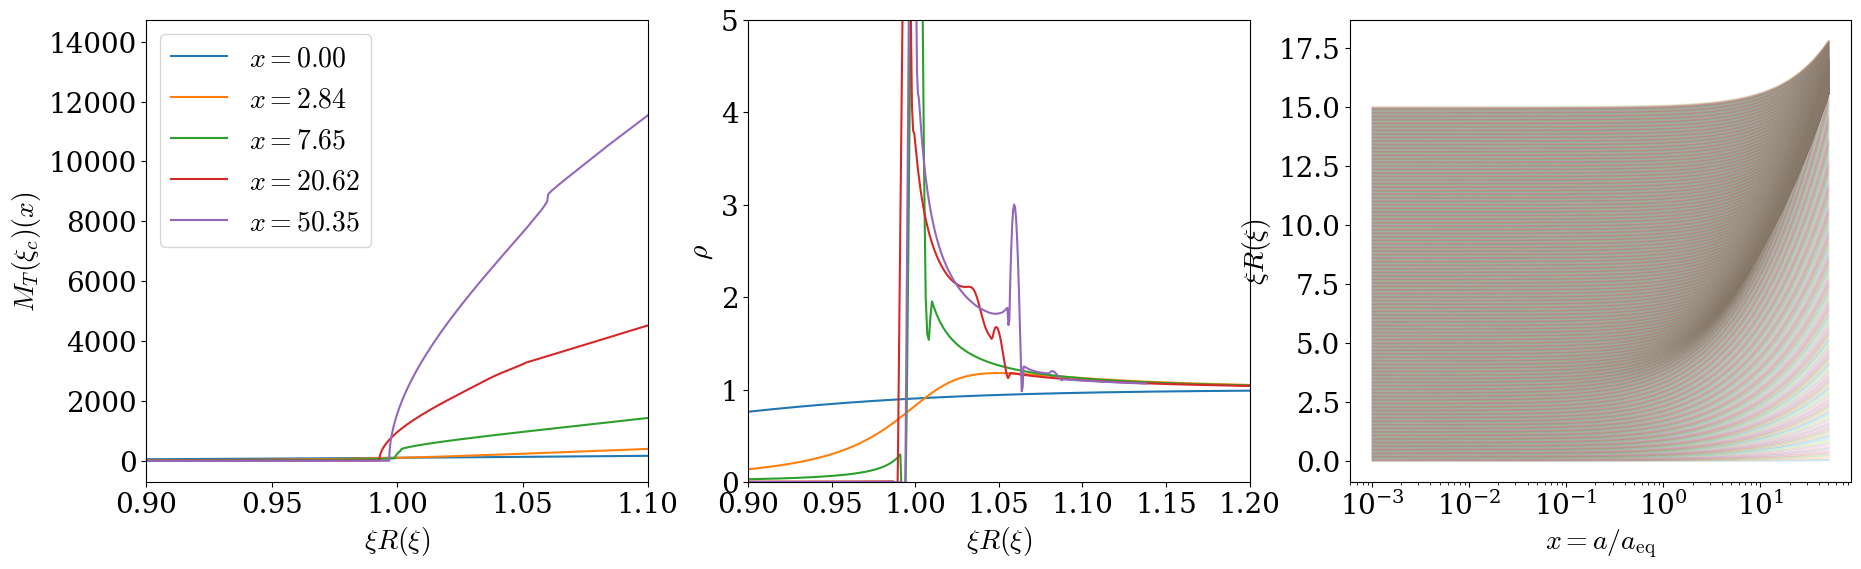

In [14]:
fig,ax=plt.subplots(1,3,figsize=(22,6))

for i in [1,-30,-20,-10,-1]:
    # physical coordinate radius
    ri =xi*Rdla[i]

    # ordering based on distance to center
    ord_ri = np.argsort(ri)
    ri_ord = ri[ord_ri]

    # Mass
    mass_ord = (bMTla[i]*4*np.pi/3*xi**3)[ord_ri]
    # Phi 
    Phi_ord = (bMTla[i])[ord_ri]

    # Point where Phi=-0.5

    b = ((Phi_ord-0.5)**2).argmin()
    r_norm = ri_ord[b]

    ax[0].plot(ri_ord/r_norm,mass_ord,'-',label=r'$x = %.2f$'%xl[i])
    
           
    # local density estimate build from (dM/dr)/4pir^2
    # Recall bMT = Mass/4pixi^3/3
    r_tab_reg = np.linspace(ri_ord[0],ri_ord[-1],2*len(ri_ord))
    minterp = np.interp(r_tab_reg, ri_ord, mass_ord)
    smooth_mass_ord = savgol_filter(minterp, 15, 3)
    rho = np.gradient(smooth_mass_ord,r_tab_reg)/(4*np.pi*r_tab_reg**2)

    ax[1].plot(r_tab_reg/r_norm,rho)
ax[0].set_xlim(0.9,1.10)
ax[1].set_xlim(0.9,1.20)
ax[1].set_ylim(0,5)
for i in range(len(xic)):
    ax[2].semilogx(xla,xic[i]*Rdla[:,i],label=r'$\xi = %.2f$'%xic[i],alpha=0.2)
ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$M_T(\xi_c)(x)$')
ax[1].set_xlabel(r'$\xi R(\xi)$');ax[1].set_ylabel(r'$\rho$')
ax[2].set_xlabel(r'$x=a/a_{\rm eq}$');ax[2].set_ylabel(r'$\xi R(\xi)$')
ax[0].legend()
#ax[1].legend()

#plt.savefig('normmassdensityevolH.pdf')

# Evolution of 1 point

Text(0, 0.5, '$R(x)$')

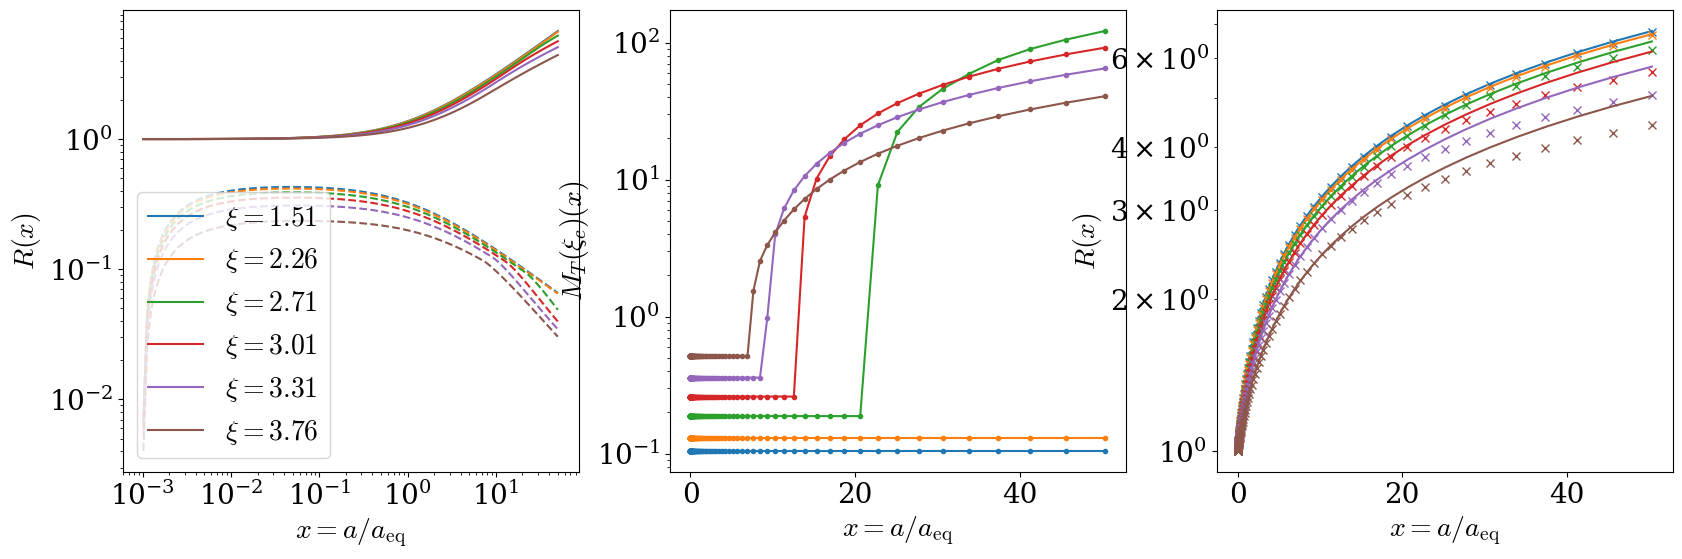

In [15]:
fig,ax=plt.subplots(1,3,figsize=(20,6))
for i_s in [100,150,180,200,220,250]:
    p = ax[0].loglog(xla,Rdla[:,i_s],label=r'$\xi=%.2f$'%xic[i_s])
    c = c=p[0].get_color()
    ax[0].loglog(xla,Pdla[:,i_s],'--',c=c)

    ax[1].semilogy(xla,bMTla[:,i_s],'.-',c=c)

    ax[2].semilogy(xla,Rdla[:,i_s],'x',c=c)
    ax[2].semilogy(xla,np.sqrt(1- (bMTla[0,i_s]-1)*xla),c=c)
ax[0].legend()

ax[0].set_xlabel(r'$x=a/a_{\rm eq}$');ax[0].set_ylabel(r'$R(x)$')
ax[1].set_xlabel(r'$x=a/a_{\rm eq}$');ax[1].set_ylabel(r'$M_T(\xi_c)(x)$')
ax[2].set_xlabel(r'$x=a/a_{\rm eq}$');ax[2].set_ylabel(r'$R(x)$')

Text(818.7240728513157, 0.5, '$R(x)$')

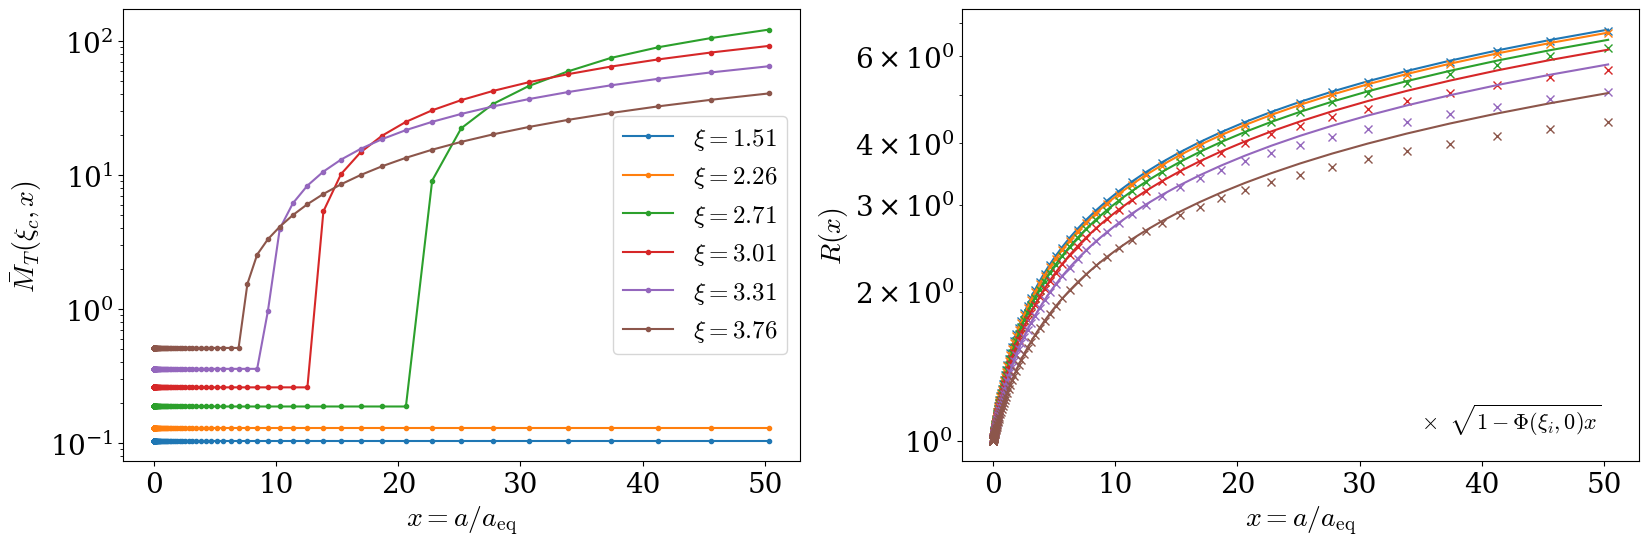

In [16]:
fig,ax=plt.subplots(1,2,figsize=(17,6))

for i_s in [100,150,180,200,220,250]:
    p = ax[0].semilogy(xla,bMTla[:,i_s],'.-',label=r'$\xi=%.2f$'%xic[i_s])
    c = c=p[0].get_color()

    ax[1].semilogy(xla,Rdla[:,i_s],'x',c=c)
    ax[1].semilogy(xla,np.sqrt(1- (bMTla[0,i_s]-1)*xla),c=c)
    
tex = r'$\times\;\;\sqrt{1-\Phi(\xi_i,0)x}$'
ax[1].text(35.0,1.2,tex,fontsize=16,horizontalalignment='left',verticalalignment='top')

#ax[2].legend()
ax[0].legend(prop={'size': 18})
fig.tight_layout(pad=2.0)
ax[0].set_xlabel(r'$x=a/a_{\rm eq}$');ax[0].set_ylabel(r'$\bar{M}_T(\xi_c,x)$')
ax[1].set_xlabel(r'$x=a/a_{\rm eq}$');ax[1].set_ylabel(r'$R(x)$')

#plt.savefig('pointevoH.pdf')

# Criteria

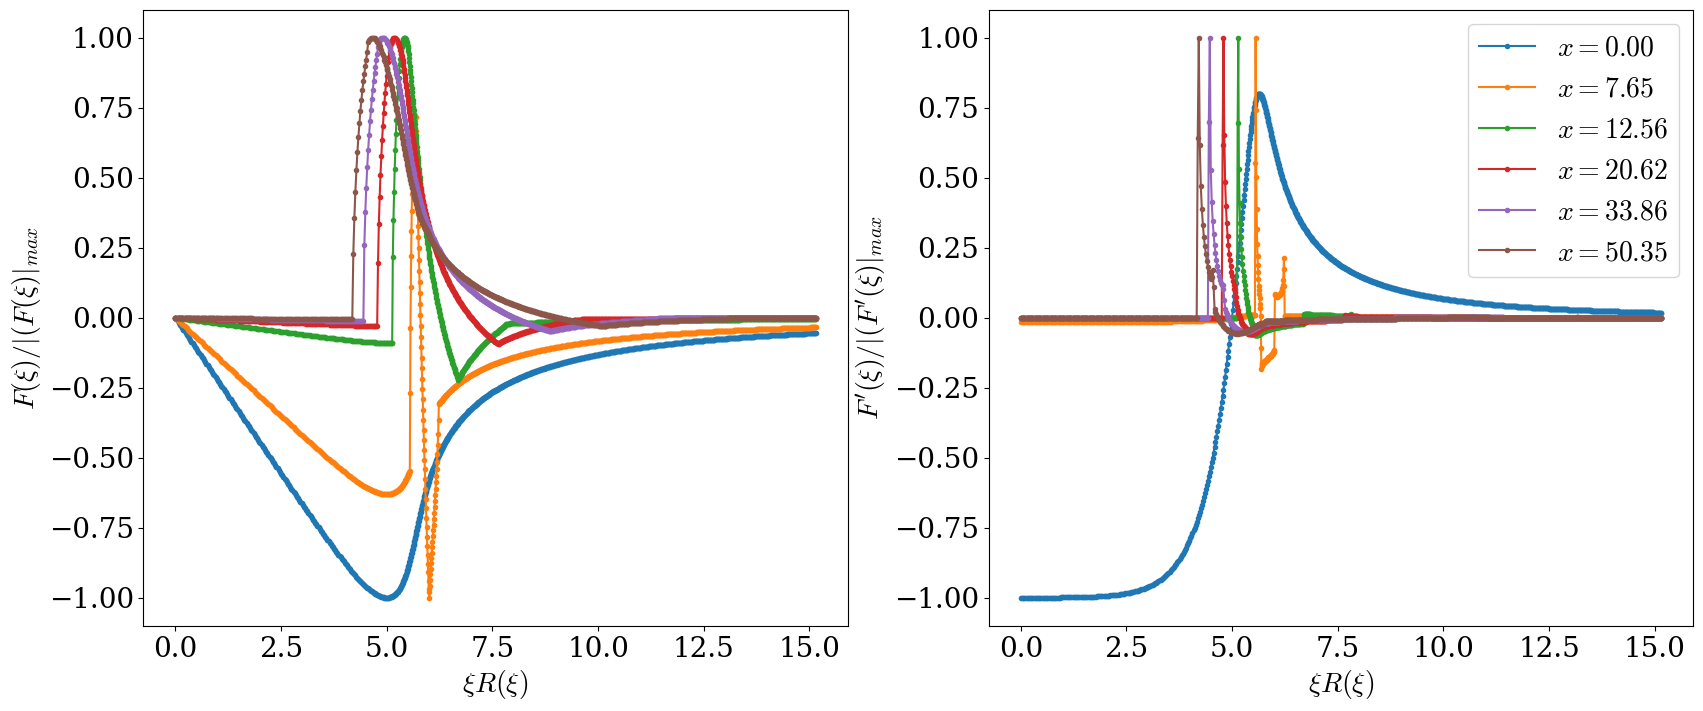

In [17]:
# First criteria

F = bMTla*0
Fp = bMTla*0

F = xi * (bMTla-1)
Fp = np.gradient(F,xi,axis=1)

# physical coordinate radius
for i in range(0,80):
    ri = xi*Rdla[i]

    # ordering based on distance to center
    ord_ri = np.argsort(ri)
    ri_ord = ri[ord_ri]

fig,ax=plt.subplots(1,2,figsize=(20,8))

for i in [0,90,-15,-10,-5,-1]:
    ax[0].plot(ri,F[i]/np.abs(F[i]).max(),'.-',label=r'$x = %.2f$'%xl[i])
    ax[1].plot(ri,Fp[i]/np.abs(Fp[i]).max(),'.-',label=r'$x = %.2f$'%xl[i])
    
ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$F(\xi)/\vert(F(\xi)\vert_{max}$')
ax[1].set_xlabel(r'$\xi R(\xi)$');ax[1].set_ylabel(r'$F^\prime(\xi)/\vert(F^\prime(\xi)\vert_{max}$')

#ax[0].set_xlim(4.0,13.0)
#ax[1].set_xlim(4.0,6.5)

#ax[0].legend()
ax[1].legend()

plt.savefig('CritFH.pdf')

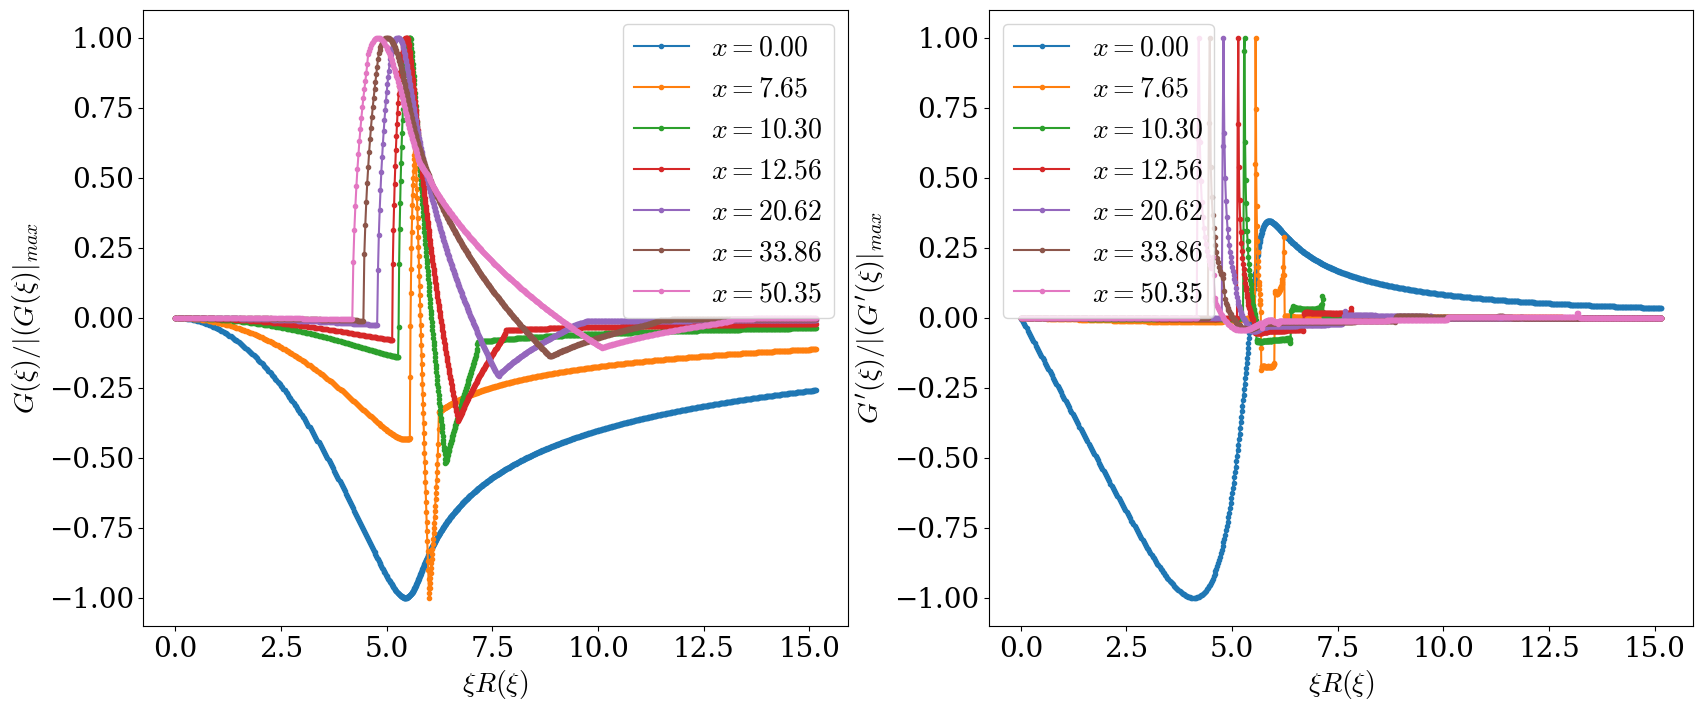

In [18]:
# Second criteria

G = bMTla*0
Gp = bMTla*0

G = (bMTla-1) * xi**2
Gp = np.gradient(G,xi,axis=1)
        
fig,ax=plt.subplots(1,2,figsize=(20,8))

for i in [0,90,-17,-15,-10,-5,-1]:
    ax[0].plot(ri,G[i]/np.abs(G[i]).max(),'.-',label=r'$x = %.2f$'%xl[i])
    ax[1].plot(ri,Gp[i]/np.abs(Gp[i]).max(),'.-',label=r'$x = %.2f$'%xl[i])
    
ax[0].set_xlabel(r'$\xi R(\xi)$');ax[0].set_ylabel(r'$G(\xi)/\vert(G(\xi)\vert_{max}$')
ax[1].set_xlabel(r'$\xi R(\xi)$');ax[1].set_ylabel(r'$G^\prime(\xi)/\vert(G^\prime(\xi)\vert_{max}$')

#ax[0].set_xlim(4.0,13.0)
#ax[1].set_xlim(4.0,13.0)

ax[0].legend()
ax[1].legend()

#plt.savefig('CritGH.pdf')

In [19]:
# Calculate x_caustic for each shell OLD

#Gp_max = xla*0
#x_cas = xla*0

#for i in range(len(xla)):
 #   for j in range(len(xic)-1):
  #      if j!=0 and Gp[i][j] > Gp[i][j-1] and Gp[i][j] > Gp[i][j+1]:
   #         Gp_max[i] = Gp[i][j]

#x_cas = 1/Gp_max
#print(x_cas[0]) #x_cas for initial time

# Calculate x_caustic for each shell NEW

Gsc = Gp/(2*xi) #Gsc is the function find maximum
Gsc_max = xla*0 
x_sc = xla*0

for i in range(len(xla)):
    for j in range(len(xic)-1):
        if j!=0 and Gsc[i][j] > Gsc[i][j-1] and Gsc[i][j] > Gsc[i][j+1]:
            Gsc_max[i] = Gsc[i][j]

x_sc = 1/Gsc_max
print(Gsc_max[0])
print(x_sc[0]) #x_sc for initial time

0.14520908486854464
6.886621459706073


/var/folders/sc/hq5cw73j2c10910m2lq9c83c0000gn/T/ipykernel_728/1892969168.py:16: RuntimeWarning: divide by zero encountered in divide
  Gsc = Gp/(2*xi) #Gsc is the function find maximum


10.299800351977416


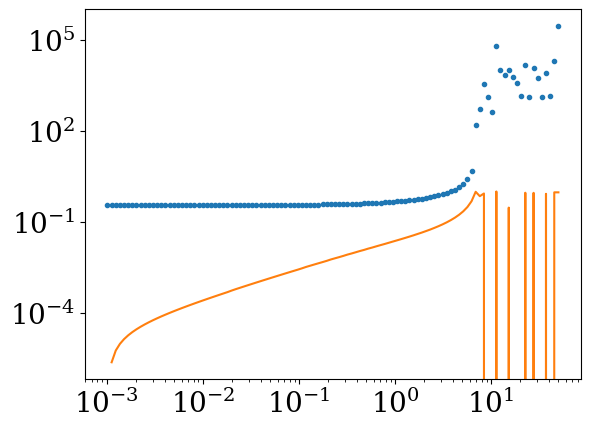

In [20]:
#Experimental xSC

def sasa(bMTla,Rdla):
    mder = bMTla*0
    aux = np.zeros(len(bMTla))
    for i in range(len(bMTla)):
        mder[i]=np.gradient(bMTla[i],xi*Rdla[i])
        aux[i] = mder[i].max()
    plt.loglog(xla,aux,'.')
    crit = (aux[1:]-aux[:-1])/aux[1:]
    plt.loglog(xla[1:],crit)
    inn = np.argmax(crit)    
    print(xla[inn])
sasa(bMTla,Rdla)

(11.0, 15.0)

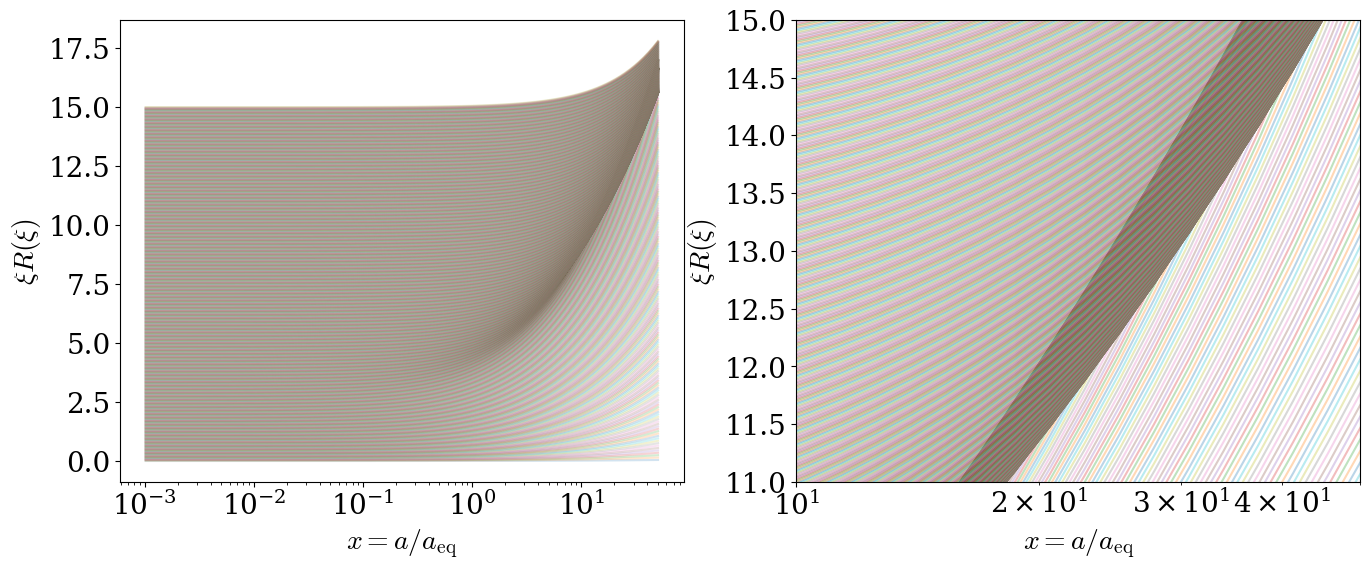

In [72]:
fig, ax=plt.subplots(1,2,figsize=(16,6))

for i in range(len(xic)):
    ax[0].semilogx(xla,xic[i]*Rdla[:,i],label=r'$\xi = %.2f$'%xic[i],alpha=0.2)
    ax[1].semilogx(xla,xic[i]*Rdla[:,i],label=r'$\xi = %.2f$'%xic[i],alpha=0.3)

ax[0].set_xlabel(r'$x=a/a_{\rm eq}$');ax[0].set_ylabel(r'$\xi R(\xi)$')
ax[1].set_xlabel(r'$x=a/a_{\rm eq}$');ax[1].set_ylabel(r'$\xi R(\xi)$')
ax[1].set_xlim(10,50);ax[1].set_ylim(11,15)

#plt.savefig('shellcrossingtest.pdf')

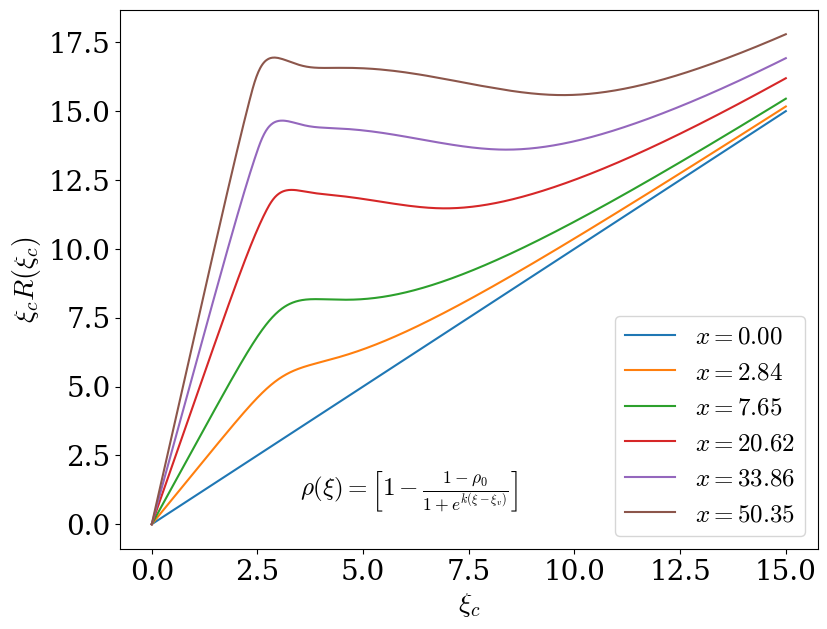

In [80]:
#Comoving displacement evolution
fig,ax=plt.subplots(1,1,figsize=(9,7))

for i in [0,-30,-20,-10,-5,-1]:#range(len(xla)):
    ax.plot(xi,xi*Rdla[i], label=r'$x = %.2f$'%xl[i])

ax.set_xlabel(r'$\xi_c$');ax.set_ylabel(r'$\xi_c R(\xi_c)$')
ax.legend(loc='lower right', prop={'size': 18})
tex = r'$\rho(\xi)=\left[1-\frac{1-\rho_0}{1+e^{k(\xi-\xi_v)}}\right]$'
ax.text(3.5,2.0,tex,fontsize=18,horizontalalignment='left',verticalalignment='top')

#plt.savefig('despcomovilH.pdf')